In [ ]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from tensorflow.keras import backend as K
from keras.layers import Rescaling, Resizing
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback, TensorBoard, BackupAndRestore
from keras import regularizers
import numpy as np
import os
import datetime
import gc #garbage collector
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import psutil
from random import shuffle, sample

2024-05-23 22:39:20.316163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 22:39:20.316298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 22:39:20.436776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
latentDim = 2048
inputShape = (64, 64, 3)
chanDim = 3
depth = 1

inputs = Input(shape=inputShape)
x = inputs


x = Conv2D(256, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)
encoder = Model(inputs, latent, name="encoder")

latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)


x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(3, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

decoder = Model(latentInputs, outputs, name="decoder")

autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=1e-2))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
!pip install gdown

In [ ]:
!gdown 'https://drive.google.com/uc?id=1UYRfDxHJVdxvLXnyRtcvt4MlUbWMM5ry'

Downloading...
From: https://drive.google.com/uc?id=1UYRfDxHJVdxvLXnyRtcvt4MlUbWMM5ry
To: /kaggle/working/real_face_best_model_64.h5
100%|██████████████████████████████████████| 70.3M/70.3M [00:02<00:00, 31.7MB/s]


In [ ]:
from tensorflow.keras.models import load_model
autoencoder = load_model('real_face_best_model_64.h5')

In [ ]:
import numpy as np
import os
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

In [ ]:
# Define the paths to your folders
real_faces_path = "/kaggle/input/real-fake-faces/face_fake/face_fake"
fake_faces_path = "/kaggle/input/real-fake-faces/face_real/face_real"

In [ ]:
# Extract the encoder part from the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder").output)
encoder.trainable = False  # Freeze the encoder

In [ ]:
!rm -r real_vs_fake

In [ ]:
import os
import shutil
import random

# Define paths
source_folder = "/kaggle/input/real-fake-faces/face_real/face_real"
destination_folder = "real_vs_fake"

# Create destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Create test, train, and valid folders within destination folder
folders = ['test', 'train', 'valid']
for folder in folders:
    os.makedirs(os.path.join(destination_folder, folder, 'real'), exist_ok=True)

# List all images in source folder
images = os.listdir(source_folder)
random.shuffle(images)

# Calculate the number of images for each category
total_images = len(images)
test_count = 5000
train_count = int(0.8 * (total_images - test_count))
valid_count = total_images - test_count - train_count

# Move images to respective folders
for folder, count in [('test', test_count), ('train', train_count), ('valid', valid_count)]:
    for i in range(count):
        image = images.pop()
        shutil.copy(os.path.join(source_folder, image), os.path.join(destination_folder, folder, 'real'))

# Copy train, valid, and test folders to real_vs_fake
# for folder in folders:
#     shutil.copytree(os.path.join(destination_folder, folder), os.path.join(destination_folder, 'real_vs_fake', folder))

In [ ]:
# Define paths
source_folder = "/kaggle/input/real-fake-faces/face_fake/face_fake"
destination_folder = "real_vs_fake"

# Create destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Create test, train, and valid folders within destination folder
folders = ['test', 'train', 'valid']
for folder in folders:
    os.makedirs(os.path.join(destination_folder, folder, 'fake'), exist_ok=True)

# List all images in source folder
images = os.listdir(source_folder)
random.shuffle(images)

# Calculate the number of images for each category
total_images = len(images)
test_count = 5000
train_count = int(0.8 * (total_images - test_count))
valid_count = total_images - test_count - train_count

# Move images to respective folders
for folder, count in [('test', test_count), ('train', train_count), ('valid', valid_count)]:
    for i in range(count):
        image = images.pop()
        shutil.copy(os.path.join(source_folder, image), os.path.join(destination_folder, folder, 'fake'))

# Copy train, valid, and test folders to real_vs_fake
# for folder in folders:
#     shutil.copytree(os.path.join(destination_folder, folder), os.path.join(destination_folder, 'real_vs_fake', folder))


In [ ]:
def count_files(folder_path):
    # Initialize count
    file_count = 0

    # Walk through the folder and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

In [ ]:
# Specify the folder path
folders = ['test', 'train', 'valid']
folder_path = 'real_vs_fake/'

for i in folders:
  print("Number of files in fake/"+str(i)+" :", count_files(folder_path+i+'/fake'))

Number of files in fake/test : 5000
Number of files in fake/train : 23070
Number of files in fake/valid : 5768


In [ ]:
# Specify the folder path
folders = ['test', 'train', 'valid']
folder_path = 'real_vs_fake/'

for i in folders:
  print("Number of files in real/"+str(i)+" :", count_files(folder_path+i+'/real'))

Number of files in real/test : 5000
Number of files in real/train : 23712
Number of files in real/valid : 5929


In [ ]:
base_path = 'real_vs_fake/'
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the data generator with augmentation
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(64, 64),
    batch_size=64,
    class_mode='binary'
)

image_gen1 = ImageDataGenerator(rescale=1./255)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(64, 64),
    batch_size=64,
    class_mode='binary'
)

image_gen1 = ImageDataGenerator(rescale=1./255.)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(64, 64),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 46782 images belonging to 2 classes.
Found 11697 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Freeze the encoder layers
for layer in encoder.layers:
    layer.trainable = False

# Using the existing encoder model
encoded_input = encoder.output

# Adding new layers for binary classification
x = Dense(1024, activation="relu")(encoded_input)
# x = Dropout(0.3)(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
# x = Dropout(0.3)(x)
outputs = Dense(1, activation="sigmoid")(x)

# Creating the binary classification model
binary_classifier = Model(encoder.input, outputs, name="binary_classifier")

# Compiling the model
binary_classifier.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=5e-4), metrics=["accuracy"])

# Summary of the new model
binary_classifier.summary()

Model: "binary_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,932,289 (41.70 MB)

 Trainable params: 2,163,841 (8.25 MB)

 Non-trainable params: 8,768,448 (33.45 MB)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Stop training if no improvement after 3 epochs
checkpoint = ModelCheckpoint('DenseNetImagenet.model.keras', monitor='val_loss', save_best_only=True)  # Save the best model


In [ ]:
history = binary_classifier.fit(
    train_flow,
    epochs = 50,
    validation_data =valid_flow,
    callbacks=[checkpoint]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/731 ━━━━━━━━━━━━━━━━━━━━ 51s 71ms/step - accuracy: 0.5174 - loss: 0.6925  

I0000 00:00:1716504325.603506      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


731/731 ━━━━━━━━━━━━━━━━━━━━ 112s 147ms/step - accuracy: 0.5259 - loss: 0.6914 - val_accuracy: 0.5339 - val_loss: 0.6868
Epoch 2/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 106s 143ms/step - accuracy: 0.5602 - loss: 0.6829 - val_accuracy: 0.5573 - val_loss: 0.6794
Epoch 3/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 105s 142ms/step - accuracy: 0.5704 - loss: 0.6785 - val_accuracy: 0.5850 - val_loss: 0.6748
Epoch 4/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 105s 142ms/step - accuracy: 0.5840 - loss: 0.6743 - val_accuracy: 0.6076 - val_loss: 0.6627
Epoch 5/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 104s 141ms/step - accuracy: 0.5856 - loss: 0.6722 - val_accuracy: 0.6031 - val_loss: 0.6657
Epoch 6/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 105s 142ms/step - accuracy: 0.5853 - loss: 0.6732 - val_accuracy: 0.5914 - val_loss: 0.6656
Epoch 7/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 104s 140ms/step - accuracy: 0.5917 - loss: 0.6694 - val_accuracy: 0.6133 - val_loss: 0.6589
Epoch 8/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 103s 139ms/step - accuracy: 0.5914 - loss: 0.66

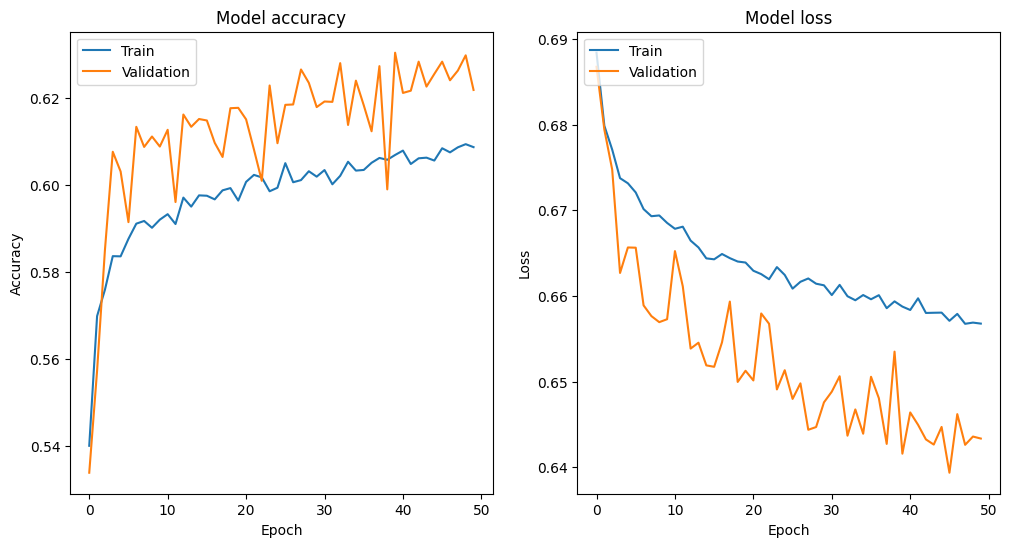

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, accuracy_score

# Accuracy and loss history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = binary_classifier.evaluate(test_flow)

  1/157 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - accuracy: 0.6875 - loss: 0.5641

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.6292 - loss: 0.6264


W0000 00:00:1716510460.433756      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
